# Installations:

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports:

In [ ]:
import torch_geometric
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
#from torch_geometric.data import HeteroData

In [1]:
import numpy as np
import torch
import pandas as pd
import os
import scipy.io

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Loading the data:

In [4]:
import os
import urllib.request
import tarfile


dataset_url = "https://www.cis.upenn.edu/~kostas/Penn_Action.tar.gz"
dataset_path = "/content/pennaction"

os.makedirs(dataset_path, exist_ok=True)

urllib.request.urlretrieve(dataset_url, "/content/pennaction.tar.gz")

with tarfile.open("/content/pennaction.tar.gz", "r:gz") as tar_ref:
    tar_ref.extractall(dataset_path)

print("Penn Action Dataset has been successfully downloaded and extracted.")
print("Dataset files are located at:", dataset_path)

Penn Action Dataset has been successfully downloaded and extracted.
Dataset files are located at: /content/pennaction


In [2]:
directory = "/content/pennaction/Penn_Action/labels"

Xs = []
Ys = []

for filename in os.listdir(directory):
    if filename.endswith(".mat"):
        # Load .mat file
        mat_data = scipy.io.loadmat(os.path.join(directory, filename))

        # Extract X and Y coordinates from the .mat file
        x = mat_data['x']
        y = mat_data['y']

        # Append X and Y coordinates to the concatenated lists
        Xs.append(x)
        Ys.append(y)

# Concatenate the X and Y coordinates along the frames axis
Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)

# Create DataFrames for X and Y coordinates
df_x = pd.DataFrame(Xs)
df_y = pd.DataFrame(Ys)

# Save X and Y coordinates as CSV files
df_x.to_csv("/content/drive/MyDrive/Behavioral/concatenated_x.csv", index=False)
df_y.to_csv("/content/drive/MyDrive/Behavioral/concatenated_y.csv", index=False)

del df_y
del df_x

# Modeling the graph:

In [3]:
Xs_cov = np.corrcoef(Xs.T)
Ys_cov = np.corrcoef(Ys.T)
edj_attr_matrix = (np.square(Ys_cov) + np.square(Xs_cov))/2
print(edj_attr_matrix.astype(np.double))

[[1.         0.29750833 0.28465865 0.34479813 0.31146237 0.22186764
  0.21164462 0.13160681 0.1077938  0.06580145 0.04055456 0.03064238
  0.02222608]
 [0.29750833 1.         0.16880615 0.36651992 0.15292109 0.40423099
  0.19630338 0.4108862  0.051547   0.16811322 0.05833339 0.08392606
  0.03203224]
 [0.28465865 0.16880615 1.         0.14673664 0.34069436 0.18246727
  0.31718169 0.0456181  0.34166631 0.01088467 0.07871219 0.01227133
  0.04644033]
 [0.34479813 0.36651992 0.14673664 1.         0.3394987  0.52451109
  0.27328059 0.27987516 0.06881943 0.17225069 0.06877518 0.08730287
  0.04064895]
 [0.31146237 0.15292109 0.34069436 0.3394987  1.         0.25736793
  0.53684787 0.08738224 0.21034251 0.03399027 0.10414943 0.01496172
  0.0375876 ]
 [0.22186764 0.40423099 0.18246727 0.52451109 0.25736793 1.
  0.40212926 0.20751235 0.07357617 0.09872006 0.06062903 0.06344254
  0.03776645]
 [0.21164462 0.19630338 0.31718169 0.27328059 0.53684787 0.40212926
  1.         0.08482643 0.15999178 0.028

In [4]:
def get_edge_idx(num_layers, num_landmarks = 13):
  edge_index = []
  edge_attr = []
  # Connect each landmark to all other landmarks in the same layer
  for layer in range(num_layers):
      start = layer * num_landmarks
      layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
      layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
      edge_index.extend(layer_edges)
      edge_attr.extend([edj_attr_matrix[i % num_landmarks, j % num_landmarks] for i, j in layer_edges])

  # Connect each landmark to the same landmark in the next layer
  for layer in range(num_layers - 1):
      start1 = layer * num_landmarks
      start2 = (layer + 1) * num_landmarks
      layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
      edge_index.extend(layer_edges)
      edge_attr.extend([1 for _ in layer_edges])
      
  edge_index = torch.tensor(edge_index).double().t().contiguous()
  edge_attr = torch.tensor(edge_attr).unsqueeze(-1)
  return edge_index, edge_attr

In [36]:
action_map = {
    "baseball_pitch": 0,
    "clean_and_jerk": 1,
    "pull_ups": 2,
    "pullup": 2,
    "strumming_guitar": 3,
    "strum_guitar": 3,
    "baseball_swing": 4,
    "golf_swing": 5,
    "push_ups": 6,
    "pushup": 6,
    "tennis_forehand": 7,
    "bench_press": 8,
    "jumping_jacks": 9,
    "sit_ups": 10,
    "situp": 10,
    "tennis_serve": 11,
    "bowling": 12,
    "bowl": 12,
    "jump_rope": 13,
    "squat": 14,
    "squats": 14
}

In [ ]:
directory = "/content/pennaction/Penn_Action/labels"

graph_list = []
label_list = []
nframes_list = []
pose_list = []


for filename in os.listdir(directory):
    if filename.endswith(".mat"):
        # Load .mat file
        mat_data = scipy.io.loadmat(os.path.join(directory, filename))
        
        # Extract relevant information from the .mat file
        x = np.array(mat_data['x'], dtype=np.float32)
        y = np.array(mat_data['y'], dtype=np.float32)
        visibility = np.array(mat_data['visibility'], dtype=np.float32)
        bbox_w = np.array(mat_data['bbox'][:, 2], dtype=np.float32)
        bbox_h = np.array(mat_data['bbox'][:, 3], dtype=np.float32)
        
        # Calculate the weighted mean for X_norm and Y_norm
        x_mean = np.sum(x * visibility, axis=1) / np.sum(visibility, axis=1)
        y_mean = np.sum(y * visibility, axis=1) / np.sum(visibility, axis=1)
        
        x_norm = (x - np.expand_dims(x_mean, axis=1)) / bbox_w[:, np.newaxis]
        y_norm = (y - np.expand_dims(y_mean, axis=1)) / bbox_h[:, np.newaxis]

        x_norm = torch.tensor(x_norm, dtype=torch.float)
        y_norm = torch.tensor(y_norm, dtype=torch.float)
        visibility = torch.tensor(visibility, dtype=torch.float)
        node_features = torch.cat([x_norm, y_norm, visibility], dim=1)
        
        edge_index, edge_attr = get_edge_idx(int(mat_data['nframes']))
        y = action_map[mat_data['action'][0]]
        label_list.append[y]
        nframes_list.append(int(mat_data['nframes']))
        pose_list.append(mat_data['pose'])

        # Create the Data object
        data = Data(x=x, edge_index=edge_index, y=y)
        graph_list.append(data)

# Convert the list of Data objects to a PyTorch Geometric dataset
dataset = torch_geometric.data.InMemoryDataset(graph_list)

In [ ]:
print(mat_data['nframes'])

In [ ]:
# from sklearn.feature_selection import mutual_info_regression

# mi_matrix_X = np.zeros((18, 18))
# mi_matrix_Y = np.zeros((18, 18))
# mi_matrix_CL = np.zeros((18, 18))

# for i in range(18):
#     for j in range(i+1, 18):
         
#         mi_X = mutual_info_regression(norm_Xs[i], norm_Xs[j], discrete_features=False)
#         mi_Y = mutual_info_regression(norm_Ys[i], norm_Ys[j], discrete_features=False)
#         mi_CL = mutual_info_regression(CLs[i], CLs[j], discrete_features=False)
        
#         mi_matrix_X[i, j] = mi_X
#         mi_matrix_X[j, i] = mi_X
#         mi_matrix_Y[i, j] = mi_Y
#         mi_matrix_Y[j, i] = mi_Y
#         mi_matrix_CL[i, j] = mi_CL
#         mi_matrix_CL[j, i] = mi_CL
        

In [ ]:
# from torch_geometric.data import Data

# epoch_len = 120
# land_mark_num = 13
# len = Xs.shape[0]-1
# overlap = 0
# graph_list = []
# order = []
# count = 0
# step = 10

# #edge_index, edge_attr = set_edges(epoch_len, land_mark_num)

# for i in range(1, len-epoch_len, step):
#   x = set_nodes(norm_Xs, norm_Ys, CLs, i, land_mark_num, epoch_len)
#   data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
#   graph_list.append(data)
#   count = count + 1
#   order.append((count, i))

# graph_num = count

* **Create and save the dataset:**

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

loader = DataLoader(graph_list, batch_size=16)
torch.save(loader, '/content/drive/MyDrive/PennActionGraphs.pth')

# pd.DataFrame(order).to_csv('/content/drive/MyDrive/order.csv')

In [ ]:
dataloader = DataLoader(dataset, batch_size=16)

# Training the Attentional Variational Graph Autoencoder:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the number of epochs to train for
num_epochs = 200

# Define the batch size for the dataloader
batch_size = 32

# Define the number of nodes and features in each node
num_nodes = 2160
num_features = 3

# Define the number of dimensions in the latent variable
hidden_dim = 24
output_dim = 6
input_dim = 3

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.multihead_attn1 = TransformerConv(input_dim, hidden_dim,
                                               concat=False, heads=4, dropout=0.4)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.multihead_attn2 = TransformerConv(hidden_dim, hidden_dim, 
                                               concat=False, heads=4, dropout=0.4)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        self.gat4 = GATConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)

        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x1 = self.multihead_attn1(x, edge_index)
        # x1 = torch.cat([x1, x], dim=-1)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)
        # x1 = F.dropout(x1, p=0.4, training=self.training)
        
        x2 = self.multihead_attn2(x1, edge_index)
        # x2 = torch.cat([x2, x1], dim=-1)
        x2 = self.bn2(x2+x1)
        x2 = F.elu(x2)
        # x2 = F.dropout(x2, p=0.4, training=self.training)
        
        x3 = self.gat3(x2, edge_index, edge_attr=edge_attr)
        # x3 = torch.cat([x3, x2], dim=-1)
        x3 = self.bn3(x3+x2)
        x3 = F.elu(x3)
        x3 = F.dropout(x3, p=0.4, training=self.training)

        x4 = self.gat4(x3, edge_index, edge_attr=edge_attr)
        x4 = self.bn4(x4+x3)
        x4 = F.elu(x4)
        x4 = F.dropout(x4, p=0.4, training=self.training)

        x = self.conv_mu(x4, edge_index)
        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

def loss_function(x_hat, z_mean, x, z_log_std):
    # kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    kl_loss = -0.5 * torch.sum(1 + z_log_std - z_mean.pow(2) - z_log_std.exp())
    recon_loss = F.mse_loss(x_hat, x)
    print(kl_loss)
    print(recon_loss)
    loss = recon_loss + 0.1*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the number of epochs to train for
num_epochs = 200

# Define the batch size for the dataloader
batch_size = 32

# Define the number of nodes and features in each node
num_nodes = 2160
num_features = 3

# Define the number of dimensions in the latent variable
hidden_dim = 24
output_dim = 16
input_dim = 3

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        # self.gmm_layers = torch.nn.ModuleList()
        # for i in range(num_gmm_layers):
        #     self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=25, dim=3))
        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # for gmm_layer in self.gmm_layers:
        #     x = gmm_layer(x, edge_index, edge_attr)
        #     x = F.elu(x)
        #     x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)
        
        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

def loss_function(x_hat, z_mean, x, z_log_std):
    # kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    kl_loss = -0.5 * torch.sum(1 + z_log_std - z_mean.pow(2) - z_log_std.exp())
    recon_loss = F.mse_loss(x_hat, x)
    print(kl_loss)
    print(recon_loss)
    loss = recon_loss + 0.1*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []

dataloader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        x_hat, z_mean, z_log_std = model(batch.x, batch.edge_index.long(), batch.edge_attr, batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        loss = F.mse_loss(x_hat, batch.x)
        # print(loss)
        # print(kl_loss(z_mean, z_log_std))
        loss = loss + 0.1 * kl_loss(z_mean, z_log_std)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= graph_num
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/200: Loss=7907422.5
Epoch 2/200: Loss=35467768.0
Epoch 3/200: Loss=0.2587668001651764
Epoch 4/200: Loss=1891164.625
Epoch 5/200: Loss=4471.87548828125
Epoch 6/200: Loss=0.18544310331344604
Epoch 7/200: Loss=0.14215297996997833
Epoch 8/200: Loss=0.11469639837741852
Epoch 9/200: Loss=135817.0
Epoch 10/200: Loss=0.1269063651561737
Epoch 11/200: Loss=0.1137852594256401
Epoch 12/200: Loss=61796828.0
Epoch 13/200: Loss=1.3518058061599731
Epoch 14/200: Loss=450238592.0
Epoch 15/200: Loss=0.11092786490917206
Epoch 16/200: Loss=0.13452674448490143
Epoch 17/200: Loss=387.86004638671875
Epoch 18/200: Loss=0.1125841736793518
Epoch 19/200: Loss=175202080.0
Epoch 20/200: Loss=0.12291140109300613
Epoch 21/200: Loss=0.11131975799798965
Epoch 22/200: Loss=0.10932847112417221
Epoch 23/200: Loss=223493872.0
Epoch 24/200: Loss=14500426.0
Epoch 25/200: Loss=0.11758638173341751
Epoch 26/200: Loss=164311360.0
Epoch 27/200: Loss=0.10691593587398529
Epoch 28/200: Loss=0.10576273500919342
Epoch 29/200: 

# Evaluating:

In [ ]:
output = model.encoder(graph_list[0].x, graph_list[0].edge_index.long(), graph_list[0].edge_attr, graph_list[0].batch)

In [ ]:
output[0].shape

torch.Size([1, 6])

In [ ]:
model.eval()


AttentionalGraphAutoencoder(
  (encoder): Encoder(
    (gat1): GATConv(3, 24, heads=1)
    (gat2): GATConv(24, 24, heads=1)
    (gat3): GATConv(24, 24, heads=1)
    (conv_mu): GCNConv(24, 24)
    (lin): Linear(in_features=24, out_features=16, bias=True)
    (lin_mean): Linear(in_features=24, out_features=16, bias=True)
    (lin_logstd): Linear(in_features=24, out_features=16, bias=True)
    (global_pool): Linear(in_features=24, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=16, out_features=24, bias=True)
    (conv1): GCNConv(24, 24)
    (conv2): GCNConv(24, 24)
    (lin2): Linear(in_features=24, out_features=24, bias=True)
    (conv3): GCNConv(24, 24)
    (lin3): Linear(in_features=24, out_features=3, bias=True)
  )
)

In [ ]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/SocioSent/my_model4.pt')

In [ ]:
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Load the saved state dictionary into the model
state_dict = torch.load('/content/drive/MyDrive/SocioSent/my_model4.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

# Embedding the graphs and saving:

In [ ]:
# Embed the input graphs using the trained VAE
embeddings = []

for graph in graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.edge_attr, graph.batch)
    embeddings.append(output[0].cpu().numpy())

embeddings = np.array(embeddings)
np.save('/content/drive/MyDrive/SocioSent/embeddings2.npy', embeddings)

In [ ]:
embeddings = np.array(embeddings)
np.save('node_embeddings.npy', embeddings)

Reload:

In [ ]:
embeddings = np.load('/content/drive/MyDrive/SocioSent/embeddings2.npy')
embedded_3d = np.load('/content/drive/MyDrive/node_embeddings_3D.npy')

In [ ]:
embeddings2 = np.array(embeddings[:,0,:])

Visualizing the embedded data:

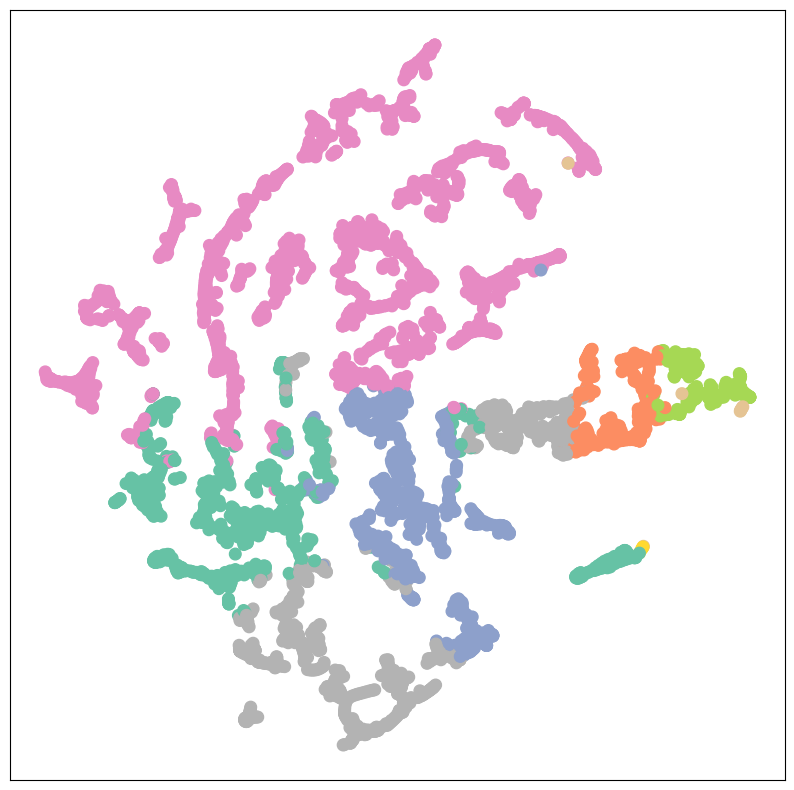

In [ ]:
visualize(torch.tensor(embeddings2), color=cluster_labels)
# visualize(torch.tensor(embeddings2), color=np.zeros([1,graph_num]))

# Clustering the Graphs:

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 10

# Initialize the GMM model
gmm = GaussianMixture(n_components=num_clusters)

# Fit the GMM model to the embedded data
gmm.fit(embeddings2)

# Predict the cluster labels for the embedded data
cluster_labels = gmm.predict(embeddings2)
print(cluster_labels)

[0 0 0 ... 1 1 1]


In [ ]:
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import hdbscan

# Assuming your 6x1000 array is called `embedded_graph`
# Transpose the array so that each row represents a data point and each column represents a feature
embedded_graph = embeddings2

# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels2 = clusterer.fit_predict(embedded_graph)

# Print the number of clusters found
# num_clusters = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print(f"Number of clusters: {num_clusters}")

# Print the cluster labels for each data point
print("Cluster labels:")
print(cluster_labels2)

Number of clusters: 8
Cluster labels:
[-1 -1  9  9  9  9 -1 -1 -1 -1 -1 -1 -1 -1  5  6  5 -1 -1 -1 -1  3 -1  9
 -1 -1  9  9 -1 -1  5  5 -1  3 -1 -1  9  6 -1 -1 -1 -1  1  1  1  1  1  1
  2  6  5  5 -1 -1  2 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  5  3 -1 -1 -1  9
  9  9  9 -1 -1 -1 -1 -1  9  9 -1  3  1 -1 -1  2 -1 -1 -1 -1 -1 -1  9  9
  9  9 -1  3 -1  4  3  3 -1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1  9  9  9 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1
  5  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  4 -1  9  9  9  9  9  9  9
 -1 -1 -1 -1  3  4  9 -1  3  3  3 -1 -1 -1 -1 -1 -1  6  6  6  6  5  5  5
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9  9  9  9  9  9  9  9  9
  9  9  9  9 -1  3  1  2  2 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  5 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1  3 -1 -1 -1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1
  5 -1  9  9  9 -1  9  9  9 -1 -1  9  9  9 -1 -1  2 -1 -1 -1 -1 -1 -1 -1
 -1  1  1  1 

# Analysis:

transition matrix:

In [ ]:
states = cluster_labels
# Get unique state values
unique_states = np.unique(cluster_labels)

# Calculate the size of the transition matrix
matrix_size = 8

# Create an empty transition matrix
transition_matrix = np.zeros((matrix_size, matrix_size))

# Calculate the number of transitions between each pair of states
for i in range(graph_num - 1):
    current_state = states[i]
    next_state = states[i + 1]
    current_state_index = np.where(unique_states == current_state)[0][0]
    next_state_index = np.where(unique_states == next_state)[0][0]
    transition_matrix[current_state_index][next_state_index] += 1

# Normalize the transition matrix
row_sums = np.sum(transition_matrix, axis=1)
transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis])

print(transition_matrix)

[[0.63265306 0.         0.         0.02040816 0.02040816 0.02040816
  0.02040816 0.28571429]
 [0.         0.89971347 0.         0.08022923 0.00286533 0.
  0.01719198 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.00649351 0.19480519 0.         0.51298701 0.         0.
  0.26623377 0.01948052]
 [0.         0.         0.07692308 0.         0.76923077 0.
  0.         0.15384615]
 [0.00826446 0.         0.         0.         0.         0.75206612
  0.23966942 0.        ]
 [0.02469136 0.02469136 0.         0.27160494 0.         0.17283951
  0.4691358  0.03703704]
 [0.19672131 0.         0.         0.03278689 0.01639344 0.01639344
  0.14754098 0.59016393]]


histogram:

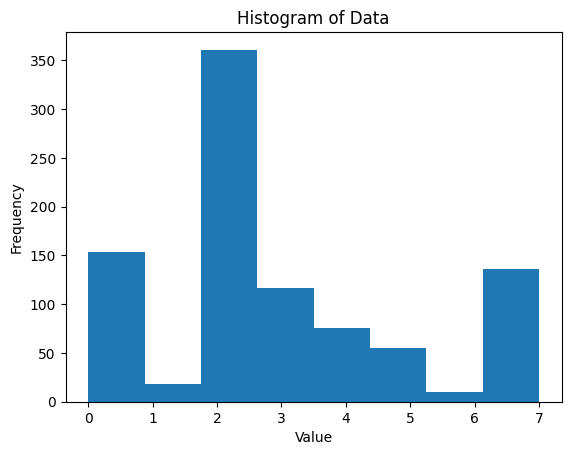

In [ ]:
plt.hist(cluster_labels, bins=8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

transition graph:

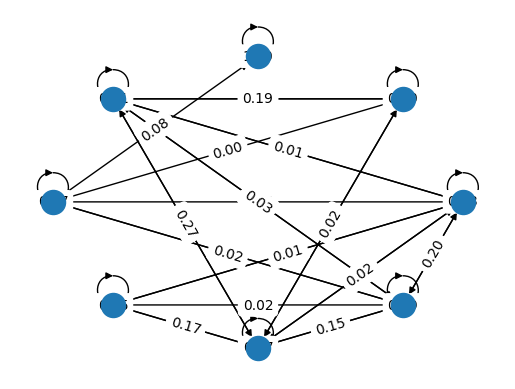

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# define the transition matrix
P = transition_matrix

# create a directed graph
G = nx.DiGraph()

# add nodes to the graph
for i in range(P.shape[0]):
    G.add_node(i)

# add edges to the graph
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i,j] > 0:
            G.add_edge(i, j, weight=P[i,j])

# set the positions of the nodes in the graph
pos = nx.circular_layout(G)

# draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# add edge labels to the graph
edge_labels = {(i, j): "{:.2f}".format(P[i,j]) for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# display the graph
plt.axis("off")
plt.show()


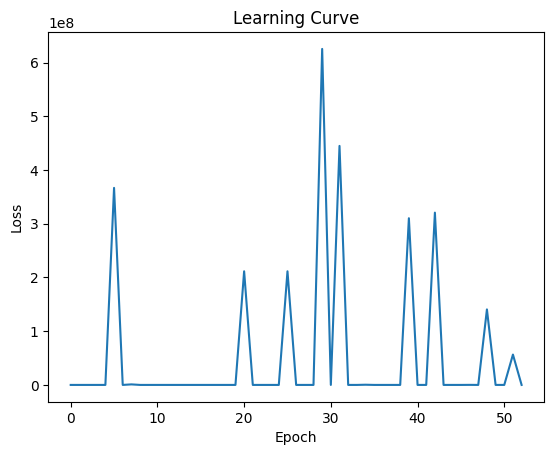

In [ ]:
plt.plot(loss_list)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
embedded_3d = tsne.fit_transform(embeddings2)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embedded_2d = tsne.fit_transform(embeddings2)

In [ ]:
np.save('/content/drive/MyDrive/SocioSent/embedded_2d.npy', embedded_2d)
np.save('/content/drive/MyDrive/SocioSent/embedded_3d.npy', embedded_3d)

In [ ]:
embedded_3d = np.load('/content/drive/MyDrive/SocioSent/embedded_3d.npy')
embedded_2d = np.load('/content/drive/MyDrive/SocioSent/embedded_2d.npy')

In [ ]:
import collections

labels = []#np.zeros([1,Xs.shape[1]])
embeds = []
embeds_3d = []
embeds_2d = []
n = 120
len = df.shape[0]
overlap = 0.5
step_size = 10

# count = collections.Counter(my_list)
# most_common = count.most_common(1)[0][0]

for i in range(0, 120):
  idx = 0
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])

for i in range(120, len-120):
  step = i // step_size
  idx = step - 4
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])

for i in range(len-120, len):
  # step = len - 120 // step_size
  idx = len - 120
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = 0 #count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[2,:])
  embeds_2d.append(embedded_2d[2,:])
  embeds_3d.append(embedded_3d[2,:])

# for _ in range(int(n*0.25)):
#     labels.append(cluster_labels[0])
#     embeds.append(embeddings2[0,:])

# for i in range(graph_num):
#   for _ in range(int(n*0.5)):
#     labels.append(cluster_labels[i])
#     embeds.append(embeddings2[i,:])

# for _ in range(int(50)):
#     labels.append(cluster_labels[graph_num-1])
#     embeds.append(embeddings2[graph_num-1,:])

  # labels[idx*n:(idx*n+n)] = la*np.ones([1,graph_num])
# labels[idx:idx+n] = la

embeds_3d = np.array(embeds_3d)
embeds_2d = np.array(embeds_2d)

In [ ]:
print(labels[1000:1500])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/SocioSent/frame_lablels.csv', index=False)

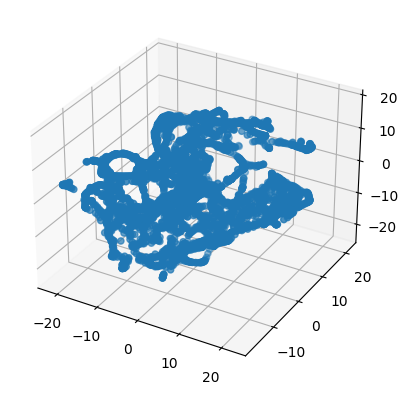

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2])
plt.show()


KeyError: ignored

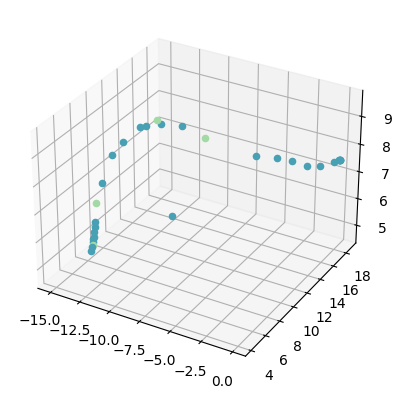

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
# tsne = TSNE(n_components=3, perplexity=30, random_state=0)
# embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, 8))
color_dict = {label: color for label, color in zip(unique_labels, colors)}

# plot each point with its corresponding color
for i in range(graph_num):
    label = cluster_labels[i]
    ax.scatter(embedded_3d[i,0], embedded_3d[i,1], embedded_3d[i,2], color=color_dict[label])

# ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2], color=cluster_labels)
plt.show()


In [ ]:
embeds = np.array(embeds)

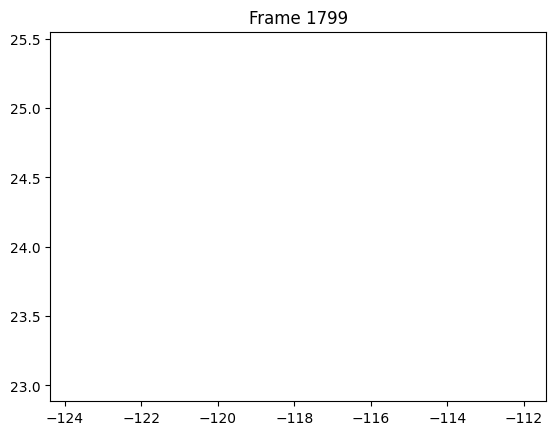

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# function to create 2D scatter plot for each frame
def plot_scatter(frame_idx, states, embeddings):
    plt.cla()  # clear previous plot
    # get x, y coordinates of embeddings for current frame
    x = embeddings[frame_idx, 0]
    y = embeddings[frame_idx, 1]
    # get the behavioral state label for current frame
    state = states[frame_idx]
    # plot the scatter plot with different color based on the behavioral state label
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
    plt.scatter(x, y, c=colors[state])
    plt.title("Frame {}".format(frame_idx))

# function to create the gif animation
def create_animation(states, embeddings, fps):
    fig = plt.figure()
    anim = animation.FuncAnimation(fig, plot_scatter, frames=embeddings.shape[0], fargs=(states, embeddings))
    anim.save('scatter_animation.gif', writer='imagemagick', fps=fps)

# create animation with 30 fps
create_animation(labels, embedded_2d[0:1800,:], fps=30)


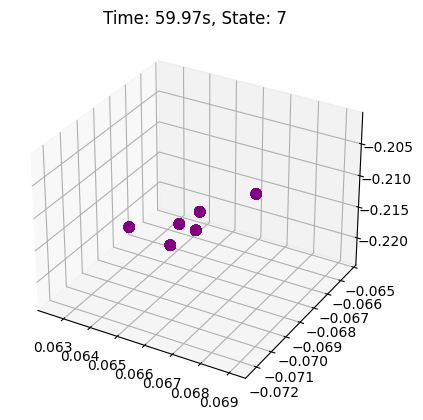

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def plot_embedding_states(embedding, states, fps=30, save_path='embedded.gif'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # colors = ['red', 'blue', 'green', 'yellow'] # add more colors if 
    colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple']
    state_to_color = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3]} # map state label to color

    x = embedding[:,0]
    y = embedding[:,1]
    z = embedding[:,2]

    frames = len(x)
    sc = ax.scatter(x[0], y[0], z[0], color=colors[states[0]], s=50)

    def update_graph(num):
        sc._offsets3d = (x[:num], y[:num], z[:num])
        sc.set_color(colors[states[num]])
        ax.set_title(f'Time: {num/fps:.2f}s, State: {states[num]}')
        return sc,

    ani = animation.FuncAnimation(fig, update_graph, frames=frames, interval=1000/fps, blit=False)

    ani.save(save_path, writer='pillow')

# Usage example
embedding = embeds[0:1800, :] # 2D embedding, shape: (num_frames, 2)
states = labels # list of state labels, length: num_frames
plot_embedding_states(embedding, states)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Define the fade-out duration in frames (7 minutes)
FADE_OUT_DURATION = 7 * 60 * 30

# Define the colors for each label
LABEL_COLORS = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray'
}

# Define the labels
LABELS = ['State {}'.format(i) for i in range(8)]

# Define the figure and axes for the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('State Space Trajectory')

# Initialize the fade-out mask
fade_out_mask = np.zeros((30*60*30,), dtype=float)

# Define the function for updating the plot
def update_plot(frame_num):
    # Get the current label and coordinates
    label = labels[frame_num]
    coord = embeds.T[:, frame_num]
    coords = embeds.T

    # Update the fade-out mask
    fade_out_mask[frame_num:] += 1
    fade_out_mask[fade_out_mask > FADE_OUT_DURATION] = FADE_OUT_DURATION
    
    # Plot the current point
    ax.scatter(coord[0], coord[1], coord[2], c=LABEL_COLORS[label], alpha=0.8, s=50)
    
    # Plot the past points
    for i in range(frame_num - FADE_OUT_DURATION, frame_num):
        if i >= 0:
            alpha = 0.8 - fade_out_mask[frame_num - i] / FADE_OUT_DURATION
            ax.scatter(coords[0, i], coords[1, i], coords[2, i], c=LABEL_COLORS[labels[i]], alpha=alpha, s=50)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
    
    # Update the title with the current frame number and label
    t = frame_num / 30
    # ax.set_title('Time: {:.1f}s, State: {}'.format(t, states[frame]))
    ax.set_title('State Space Trajectory (Frame: {} / Label: {} / Time: {:.1f}s)'.format(frame_num, LABELS[label], t))
    
    # Return the plot objects
    return ax

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=30*60*30, interval=33.3, blit=False)

# Save the animation as a GIF
ani.save('state_space_trajectory.gif', writer='imagemagick', fps=30)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def fade(alpha, t_start, t_curr):
    age = t_curr - t_start
    if age < 0:
        return 1
    elif age < 300:
        return alpha
    elif age < 420:
        return alpha * (420 - age) / 120
    else:
        return 0

def update(frame, states, embeddings):
    ax.clear()
    t = frame / 30
    ax.set_title('Time: {:.1f}s, State: {}'.format(t, states[frame]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    for i, state in enumerate(states):
        if i <= frame:
            alpha = fade(0.7, i/30, t)
            if alpha > 0:
                ax.scatter(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2],
                           color=plt.cm.tab10(state / 10.), alpha=alpha, s=20)
    return []

# Example inputs
embeddings = embeds_3d
states = labels

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ani = animation.FuncAnimation(fig, update, frames=20000, fargs=(states, embeddings),
                              interval=33.33, blit=True)

# Save animation as GIF
ani.save('/content/drive/MyDrive/SocioSent/embedded_states.gif', writer='pillow', fps=30)


In [ ]:

ani.save('embedded_states.mp4', writer='pillow', fps=30)

In [ ]:
np.savetxt('/content/drive/MyDrive/SocioSent/embeds_3d.csv', embeds_3d, delimiter=',')
np.savetxt('/content/drive/MyDrive/SocioSent/embeds_2d.csv', embeds_2d, delimiter=',')
np.savetxt('/content/drive/MyDrive/SocioSent/labels.csv', labels, delimiter=',')